In [275]:
import keras
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
context = data.init()
n = 2
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9947916666666667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9947916666666667
 |>  100
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 2)


In [156]:
n = 10
min_f = 3
max_f = 15
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
# x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, 
    n_polyrythms=1,
    n_channels=3,
    multiTrack=multiTrack)

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.002083333333333
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9999999999999998
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.001041666666667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9968749999999997
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0093750000000004
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9989583333333334
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9999999999999998
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.008333333333333
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0031250000000003
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9947916666666663
 |>  100
 [INFO] : 
 |  reduced dims:
 |  (10, 100, 3)


In [157]:
n = 3
total = 1000 * 1
x_train_ = x_train
x_train = np.concatenate([x_train_[:n] for _ in range(int(total/n))])
x_test = np.concatenate([x_train_[n:n+n] for _ in range(int(total/n))])

<strong>Usage of keras.image.ImageDataGenerator requires 3 dims</strong>

In [158]:
x_train = x_train.reshape(list(x_train.shape) + [1])
x_test = x_test.reshape(list(x_test.shape) + [1])
x_train.shape

(999, 100, 3, 1)

In [159]:
y_train = x_train
y_test = x_test

In [160]:
# y_train = np.concatenate([list(range(n)) for _ in range(int(total/n)+1)])[:total]
# y_train = keras.utils.to_categorical(y_train)
# y_test = y_train[-500:]
# y_train.shape

In [161]:
num_classes = n
m = 9000

In [162]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train = x_train[:m].astype('float32')
# x_test = x_test[:1000].astype('float32')
# y_train = y_train[:m]
# y_test = y_train[:1000]
# x_train /= 255
# x_test /= 255
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

m (30, 3)


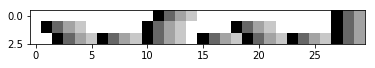

In [163]:
# plt.imshow(x_train[0,:,:,0])
plot.multi(x_train[0,:30,:,0])

In [164]:
input_shape = x_train[0].shape

In [255]:
timesteps, notes, channels = input_shape

encoder_input = Input(shape=(None, None, channels))
x = encoder_input

# 1D
x = Reshape((-1, 1))(x)
x = Conv1D(64, 3, activation='relu', padding='valid')(x)
x = Conv1D(64, 3, activation='relu', padding='valid')(x)
x = AveragePooling1D(2)(x)
x = Conv1D(128, 3, activation='relu', padding='valid')(x)
x = Conv1D(128, 3, activation='relu', padding='valid')(x)
x = Reshape((-1, 1, 1))(x)

x = Reshape((-1, 128))(x)
n_capsules = 10
capsule_dim = 6
n_routings=3
share_weights=True
capsule = Capsule(n_capsules, capsule_dim, n_routings, share_weights)(x)
x = capsule

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary.
# x = Length(name='capsnet')(capsule)
# x = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
# x = Lambda(lambda z: K.sqrt(K.sum(K.square(z), -1)))(capsule)

# x = Flatten()(capsule)
# x = Dense(np.prod(input_shape), activation='sigmoid')(x)
# x = Reshape(input_shape)(x)


encoder_output = x

encoder_model = Model(encoder_input, encoder_output, name='encoder-')
encoder_model.summary() # output.shape = (None, 10)?

shared weights, shape = (1, 128, 60) 7680
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, None, None, 1)     0         
_________________________________________________________________
reshape_53 (Reshape)         (None, None, 1)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, None, 64)          256       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 64)          12352     
_________________________________________________________________
average_pooling1d_7 (Average (None, None, 64)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 128)         24704     
_________________________________________________________________
conv1d_32 (Conv1D)           (None

In [256]:
# encoder_model.compile(loss='mse', optimizer='adam')
# x = encoder_model.predict(x_train[:10])
# x.shape # == (10, 100, 3, 1)

In [257]:
# encoder_model.fit(x_train[:10], x_train[:10])

In [258]:
# encoder_model.compile(loss='mse', optimizer='adam')
# x = encoder_model.predict(x_train[:10])
# x.shape # == (10, 100, 3, 1)

In [259]:
def list_decoders(input_shape, output_shape, intermediate_dim=150, conv=True):
    # cols, rows, color-channels (rgb)
    timesteps, notes, channels = output_shape

    # we instantiate these layers separately so as to reuse them later
    decoders = []
    # first process the capsule features independently
    decoders += [ Dense(64, activation='relu') ]
    decoders += [ Dense(128, activation='relu') ]
    # decoders += [ LSTM(32, return_sequences=True) ]

    if len(input_shape) > 1:
        decoders += [ Flatten() ]
    
    decoders += [ Dense(100, activation='relu') ]
    decoders += [ Reshape((-1,1))]
    decoders += [ LSTM(32, return_sequences=True) ]
    decoders += [ Dense(64, activation='relu') ]
    # deconv?
    if conv:
        decoders += [ Conv1D(128, 3, strides=1, activation='relu', padding='same') ]
        # TODO prevent blurring of output
        decoders += [ Conv1D(3, 2, strides=1, activation='sigmoid', padding='same') ]
    else:
        decoders += [ Dense(notes, activation='sigmoid') ]

    # output_shape = (timesteps, notes, channels)
#     decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [260]:
encoder_output_shape = (n_capsules, capsule_dim) # (n_capsules, capsule_dim,)
# encoder_output_shape = (n_capsules,) # (n_capsules, capsule_dim,)
# encoder_output_shape = (160,)
decoder_input_shape = encoder_output_shape
decoder_input = Input(shape=decoder_input_shape)
# decoder_input = encoder_model(encoder_input)
# decoder_input = encoder_output

decoder_pipeline = list_decoders(decoder_input_shape, output_shape=input_shape)
decoded = utils.composition(decoder_pipeline, decoder_input, verbose=True)

decoder_model = Model(decoder_input, decoded, name='decoder-')
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 10, 6)             0         
_________________________________________________________________
dense_100 (Dense)            (None, 10, 64)            448       
_________________________________________________________________
dense_101 (Dense)            (None, 10, 128)           8320      
_________________________________________________________________
flatten_28 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_102 (Dense)            (None, 100)               128100    
_________________________________________________________________
reshape_56 (Reshape)         (None, 100, 1)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 100, 32)           4352      
__________

In [261]:
ae_input = encoder_input
# ae_output = decoded
ae_output = decoder_model(encoder_model(encoder_input))
# ae = Model(encoder_input, decoder_model(encoder_model(encoder_input)))
# ae_output = decoded.
# ae_encoder_output = encoder_model(encoder_input)
# ae_decoder_output = decoder_model(ae_encoder_output)
# ae_output = [ae_encoder_output, ae_decoder_output]

ae = Model(ae_input, ae_output, name='AE')
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, None, None, 1)     0         
_________________________________________________________________
encoder- (Model)             (None, 10, 6)             94272     
_________________________________________________________________
decoder- (Model)             (None, 100, 3, 1)         169191    
Total params: 263,463
Trainable params: 263,463
Non-trainable params: 0
_________________________________________________________________


In [262]:
# def loss(alpha=1., beta=1.):
#     encoder_loss = margin_loss(encoder_input, encoder_output)
#     xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(ae_input), K.flatten(ae_output))
#     # xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(y1), K.flatten(y2))
#     # return = K.mean(alpha * encoder_loss + beta * xent_loss)
#     loss = K.mean(encoder_loss + xent_loss)
#     return xent_loss

In [263]:
def loss(y_true, y_pred, alpha=1., beta=1.):
#     y_true, y_pred = K.flatten(y_true), K.flatten(y_pred)
    # xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(ae_input), K.flatten(ae_output))
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(y_true, y_pred)
    mse_loss = K.mean_squared_error(y_true, y_pred)
    # return = K.mean(alpha * encoder_loss + beta * xent_loss)
    loss = K.mean(encoder_loss + beta * mse_loss)
    return loss

In [264]:
# loss_ = loss()
# ae.add_loss(loss_)
# ae.compile(optimizer='adam')

In [265]:
# ae = encoder_model

In [266]:
# loss = [margin_loss, 'binary_crossentropy']
loss = 'binary_crossentropy' # mse mae binary_crossentropy rmsprop adadelta
ae.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','binary_crossentropy'])

In [267]:
# loss_ = lambda y_true, y_pred = loss(ae_input, ae_output)
# loss_ = loss
# loss_ = 'binary_crossentropy'

# ae.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

In [268]:
phase_mod = 0.1
whitening = False

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
#         zca_epsilon=10,
        zca_whitening=whitening,
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.,  # note-channel mod, but not shuffled
        height_shift_range=phase_mod,  # start_t, phase
        horizontal_flip=False,  # reverse
        vertical_flip=False)

datagen.fit(x_train)

In [269]:
batch_size = 128
epochs = 30

In [270]:
y_train.shape

(999, 100, 3, 1)

In [271]:
data_augmentation = False
data_augmentation = True

callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

if not data_augmentation:
    print('Not using data augmentation.')
#     history = ae.fit(x_train, epochs=epochs, validation_data=(x_test, None))
    history = ae.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        shuffle=True)
else:
    print('Using real-time data augmentation.')    
    history = ae.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        workers=4)

Using real-time data augmentation.
Epoch 1/30
8/8 [==============================] - 11s 1s/step - loss: 0.6306 - acc: 0.4374 - mean_absolute_error: 0.3120 - binary_crossentropy: 0.6306 - val_loss: 0.7321 - val_acc: 0.2856 - val_mean_absolute_error: 0.3122 - val_binary_crossentropy: 0.7321
Epoch 2/30
8/8 [==============================] - 5s 683ms/step - loss: 0.5878 - acc: 0.4380 - mean_absolute_error: 0.2758 - binary_crossentropy: 0.5878 - val_loss: 0.7422 - val_acc: 0.2856 - val_mean_absolute_error: 0.3133 - val_binary_crossentropy: 0.7422
Epoch 3/30
8/8 [==============================] - 7s 885ms/step - loss: 0.5807 - acc: 0.4389 - mean_absolute_error: 0.2708 - binary_crossentropy: 0.5807 - val_loss: 0.7495 - val_acc: 0.2856 - val_mean_absolute_error: 0.3136 - val_binary_crossentropy: 0.7495
Epoch 4/30
8/8 [==============================] - 6s 746ms/step - loss: 0.5751 - acc: 0.4401 - mean_absolute_error: 0.2669 - binary_crossentropy: 0.5751 - val_loss: 0.7656 - val_acc: 0.2856 - v

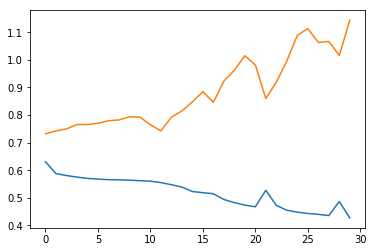

In [276]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

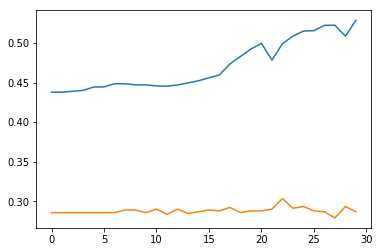

In [277]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

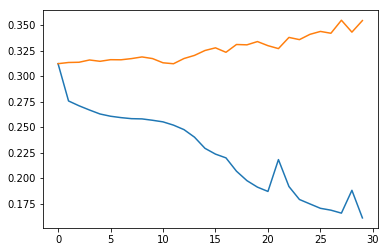

In [278]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [279]:
# i = 1
# x = datagen.random_transform(x_train[i])
# plot.multi(x[:30,:,0])
# plot.multi(x_train[i,:30,:,0])

In [280]:
# i = 1
# x = datagen.standardize(x_train[i:i+batch_size])
# x.shape
# x = x[0]
# plot.multi(x[:30,:,0])
# plot.multi(x_train[i,:30,:,0])

m (30, 3)


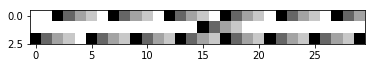

m (30, 3)


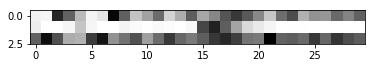

In [281]:
i = 1
x = ae.predict(x_train[:10])
plot.multi(x_train[i,:30,:,0])
plot.multi(x[i,:30,:,0])

m (30, 3)


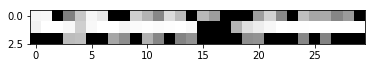

In [282]:
x2 = x[i,:,:,0]
threshold = midi.MIDI_NOISE_FLOOR
idx = x2[:,:] > threshold
x2[idx] = 1
plot.multi(x2[:30])